In [6]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import bspline, vform, geometry, vis, solvers, utils, topology, approx
from pyiga import assemble
from sksparse.cholmod import cholesky

from scipy.sparse.linalg import onenormest, splu, LinearOperator

from pyiga import bspline
from pyiga import utils
from pyiga.bspline import BSplineFunc
from pyiga.tensor import apply_tprod
from pyiga import adaptive as adap

import functools
import itertools

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

Populating the interactive namespace from numpy and matplotlib


/home/wolfman/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['hstack', 'identity', 'cholesky']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [7]:
def draw_loglog_slope(fig, ax, origin, width_inches, slope, inverted=False, color=None, polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None):
    """
    This function draws slopes or "convergence triangles" into loglog plots.
    @param fig: The figure
    @param ax: The axes object to draw to
    @param origin: The 2D origin (usually lower-left corner) coordinate of the triangle
    @param width_inches: The width in inches of the triangle
    @param slope: The slope of the triangle, i.e. order of convergence
    @param inverted: Whether to mirror the triangle around the origin, i.e. whether 
        it indicates the slope towards the lower left instead of upper right (defaults to false)
    @param color: The color of the of the triangle edges (defaults to default color)
    @param polygon_kwargs: Additional kwargs to the Polygon draw call that creates the slope
    @param label: Whether to enable labeling the slope (defaults to true)
    @param labelcolor: The color of the slope labels (defaults to the edge color)
    @param label_kwargs: Additional kwargs to the Annotation draw call that creates the labels
    @param zorder: The z-order value of the triangle and labels, defaults to a high value
    """

    if polygon_kwargs is None:
        polygon_kwargs = {}
    if label_kwargs is None:
        label_kwargs = {}

    if color is not None:
        polygon_kwargs["color"] = color
    if "linewidth" not in polygon_kwargs:
        polygon_kwargs["linewidth"] = 0.75 * mpl.rcParams["lines.linewidth"]
    if labelcolor is not None:
        label_kwargs["color"] = labelcolor
    if "color" not in label_kwargs:
        label_kwargs["color"] = polygon_kwargs["color"]
    if "fontsize" not in label_kwargs:
        label_kwargs["fontsize"] = 0.75 * mpl.rcParams["font.size"]

    if inverted:
        width_inches = -width_inches
    if zorder is None:
        zorder = 10

    # For more information on coordinate transformations in Matplotlib see
    # https://matplotlib.org/3.1.1/tutorials/advanced/transforms_tutorial.html

    # Convert the origin into figure coordinates in inches
    origin_disp = ax.transData.transform(origin)
    origin_dpi = fig.dpi_scale_trans.inverted().transform(origin_disp)

    # Obtain the top-right corner in data coordinates
    corner_dpi = origin_dpi + width_inches * np.array([1.0, 0.0])
    corner_disp = fig.dpi_scale_trans.transform(corner_dpi)
    corner = ax.transData.inverted().transform(corner_disp)

    (x1, y1) = (origin[0], origin[1])
    x2 = corner[0]

    # The width of the triangle in data coordinates
    width = x2 - x1
    # Compute offset of the slope
    log_offset = y1 / (x1 ** (-slope))

    y2 = log_offset * (x2 ** (-slope))
    height = y2 - y1

    # The vertices of the slope
    a = origin
    b = corner
    c = [x2, y2]

    # Draw the slope triangle
    X = np.array([a, b, c])
    triangle = plt.Polygon(X[:3,:], fill=False, zorder=zorder, **polygon_kwargs)
    ax.add_patch(triangle)

    # Convert vertices into display space
    a_disp = ax.transData.transform(a)
    b_disp = ax.transData.transform(b)
    c_disp = ax.transData.transform(c)

    # Figure out the center of the triangle sides in display space
    bottom_center_disp = a_disp + 0.5 * (b_disp - a_disp)
    bottom_center = ax.transData.inverted().transform(bottom_center_disp)

    right_center_disp = b_disp + 0.5 * (c_disp - b_disp)
    right_center = ax.transData.inverted().transform(right_center_disp)

    # Label alignment depending on inversion parameter
    va_xlabel = "bottom" if not inverted else "top"
    ha_ylabel = "left" if not inverted else "right"

    # Label offset depending on inversion parameter
    offset_xlabel = [0.0, 0.33 * label_kwargs["fontsize"]] if not inverted else [0.0, -0.33 * label_kwargs["fontsize"]]
    offset_ylabel = [0.33 * label_kwargs["fontsize"], 0.0] if not inverted else [-0.33 * label_kwargs["fontsize"], 0.0]

    # Draw the slope labels
    ax.annotate("$1$", bottom_center, xytext=offset_xlabel, textcoords='offset points', ha="center", va=va_xlabel, zorder=zorder, **label_kwargs)
    ax.annotate(f"${slope}$", right_center, xytext=offset_ylabel, textcoords='offset points', ha=ha_ylabel, va="center", zorder=zorder, **label_kwargs)


In [8]:
def condest(A):
    luA = splu(A)
    iA = LinearOperator(luA.shape, matvec = lambda x : luA.solve(x), rmatvec = lambda x : luA.solve(x))
    return onenormest(iA)*onenormest(A)

def pcg(Afuns, f, tol = 1e-5, maxit = 100, pfuns = 1, output = False):     
    maxit = int(maxit)
    if not callable(pfuns):
        pfun = lambda x : x
        # splu_pfun = sp.linalg.splu(pfuns,permc_spec='COLAMD')
        # pfun = lambda x : splu_pfun.solve(x)
    else:
        pfun = pfuns
    if not callable(Afuns):
        Afun = lambda x : Afuns@x
    else:
        Afun = Afuns
    if not isinstance(f,np.ndarray):
        d = f.A.ravel()
    else:
        d = f.ravel() 
    # print('Cond about',condest(pfuns@Afuns))
    w = pfun(d)
    rho = w@d
    err0 = np.sqrt(rho)
    s = w
    u = 0*d.copy()
    for it in range(maxit):
        As = Afun(s)
        alpha = rho/(As@s)
        u = u + alpha*s
        d = d - alpha*As
        w = pfun(d)
        rho1 = rho
        rho = w@d
        err = np.sqrt(rho)
        if err < tol*err0:
            break
        beta = rho/rho1
        s = w + beta*s
    if output:
        print('pcg stopped after ' + str(it) + ' iterations with relres ' + str(err/err0))
    return u,it,d

In [41]:
def Inductor(deg,N,a=1.25,b=0.5,c=1.5-0.0125,d=0.025):
    kvs = 27*[3*(bspline.make_knots(deg, 0.0, 1.0, N),)]
    
    geos=[
        geometry.unit_cube().scale((a,a,c)).translate((0,0,0)),
        geometry.unit_cube().scale((b,a,c)).translate((a,0,0)),
        geometry.unit_cube().scale((a,a,c)).translate((a+b,0,0)),
        geometry.unit_cube().scale((a,b,c)).translate((0,a,0)),
        geometry.unit_cube().scale((b,b,c)).translate((a,a,0)),
        geometry.unit_cube().scale((a,b,c)).translate((a+b,a,0)),
        geometry.unit_cube().scale((a,a,c)).translate((0,a+b,0)),
        geometry.unit_cube().scale((b,a,c)).translate((a,a+b,0)),
        geometry.unit_cube().scale((a,a,c)).translate((a+b,a+b,0)),
        
        geometry.unit_cube().scale((a,a,d)).translate((0,0,c)),
        geometry.unit_cube().scale((b,a,d)).translate((a,0,c)),
        geometry.unit_cube().scale((a,a,d)).translate((a+b,0,c)),
        geometry.unit_cube().scale((a,b,d)).translate((0,a,c)),
        geometry.unit_cube().scale((b,b,d)).translate((a,a,c)),
        geometry.unit_cube().scale((a,b,d)).translate((a+b,a,c)),
        geometry.unit_cube().scale((a,a,d)).translate((0,a+b,c)),
        geometry.unit_cube().scale((b,a,d)).translate((a,a+b,c)),
        geometry.unit_cube().scale((a,a,d)).translate((a+b,a+b,c)),
        
        geometry.unit_cube().scale((a,a,c)).translate((0,0,c+d)),
        geometry.unit_cube().scale((b,a,c)).translate((a,0,c+d)),
        geometry.unit_cube().scale((a,a,c)).translate((a+b,0,c+d)),
        geometry.unit_cube().scale((a,b,c)).translate((0,a,c+d)),
        geometry.unit_cube().scale((b,b,c)).translate((a,a,c+d)),
        geometry.unit_cube().scale((a,b,c)).translate((a+b,a,c+d)),
        geometry.unit_cube().scale((a,a,c)).translate((0,a+b,c+d)),
        geometry.unit_cube().scale((b,a,c)).translate((a,a+b,c+d)),
        geometry.unit_cube().scale((a,a,c)).translate((a+b,a+b,c+d)),
    ]
    
    M=topology.PatchMesh3D(list(zip(kvs,geos)))
    M.rename_boundary(0,'N')
    M.set_boundary_id({'D0':{(0,0),(1,0),(2,0),(3,0),(5,0),(6,0),(7,0),(8,0),(18,1),(19,1),(20,1),(21,1),(23,1),(24,1),(25,1),(26,1)}, 'D1':{(4,0),(22,1)}})
    M.rename_domain(0,'Air')
    M.set_domain_id({'Fe':{4,22}})
    return M

In [42]:
M = Inductor(2,3)

In [44]:
M.outer_boundaries

{'N': {(0, 2),
  (0, 4),
  (1, 2),
  (2, 2),
  (2, 5),
  (3, 4),
  (5, 5),
  (6, 3),
  (6, 4),
  (7, 3),
  (8, 3),
  (8, 5),
  (9, 2),
  (9, 4),
  (10, 2),
  (11, 2),
  (11, 5),
  (12, 4),
  (14, 5),
  (15, 3),
  (15, 4),
  (16, 3),
  (17, 3),
  (17, 5),
  (18, 2),
  (18, 4),
  (19, 2),
  (20, 2),
  (20, 5),
  (21, 4),
  (23, 5),
  (24, 3),
  (24, 4),
  (25, 3),
  (26, 3),
  (26, 5)},
 'D0': {(0, 0),
  (1, 0),
  (2, 0),
  (3, 0),
  (5, 0),
  (6, 0),
  (7, 0),
  (8, 0),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1)},
 'D1': {(4, 0), (22, 1)}}

In [9]:
mu0 = 4*pi*1e-7
mu = {'Fe':2500*mu0, 'Air': mu0}
dir_bcs = {'D0': lambda x,y,z: 0., 'D1': lambda x,y,z: (1-(4*x-6)**2)*(1-(4*y-6)**2)}

In [10]:
for deg, maxiter in zip((2,),(5,)):
    M=Inductor(deg,deg+1)
    MP = assemble.Multipatch(M, automatch=True)
    
    cg_it=np.zeros(maxiter)
    numdofs = np.zeros(maxiter)
    time_mesh = np.zeros(maxiter)
    time_solve = np.zeros(maxiter)
    nnz = np.zeros(maxiter)
    nnzQ = np.zeros(maxiter)
    Eh=np.zeros(maxiter)
    uh=[]
    P=[]
    
    for i in range(maxiter):
        Ah = sum([MP.assemble_volume(' mu * inner(grad(u),grad(v)) * dx', arity=2, domain_id=d, mu=mu[d]) for d in mu])
        bcs = MP.compute_dirichlet_bcs(dir_bcs)
        LS = assemble.RestrictedLinearSystem(Ah, np.zeros(Ah.shape[1]), bcs)
        
        numdofs[i]=MP.numdofs
        nnz[i] = LS.A.nnz
        nnzQ[i] = 100*LS.A.nnz/np.prod(LS.A.shape)
        
        t=time.time()
        D = scipy.sparse.spdiags(1/LS.A.diagonal(),[0],*(LS.A.shape))
        u, it, res = pcg(LS.A,LS.b,maxit=10000, pfuns= lambda x: D@x)
        uh.append(LS.complete(u))
        time_solve[i] = time.time()-t
        
        Eh[i] = sqrt(0.5 * uh[-1] @ Ah @ uh[-1])
        cg_it[i]=it
        
        print('################################################################')
        print('DoFs: ' + str(MP.numdofs))
        print('Energy: '+str(Eh[i]))
        print('solving time: '+str(time_solve[i]))
        print('#CG-Iterations: '+str(it))
        #print('Residual: '+str(np.linalg.norm(res)))
        
        t = time.time()
        if i < maxiter-2:
            if (i+1)%100==0:
                P.append(MP.h_refine(h_ref=-1, return_P=1))
            else:
                P.append(MP.h_refine(h_ref='q', return_P=1))
        elif i == maxiter-2:
            P.append(MP.p_refine(p_inc=1, return_P=1))
        else:
            pass
        M.draw(knots=1)
        time_mesh[i] = time.time()-t
        
    for k in reversed(range(1,len(P))):
        P[k-1]=P[k]@P[k-1]

    Aherr = np.zeros(maxiter)
    
    for i in range(len(uh)-1):
        eh = P[i]@uh[i]-uh[-1]
        Aherr[i] = 0.5* eh @ Ah @ eh

    Aherr = sqrt(Aherr)
    
    np.savetxt('Ip'+str(deg)+'n'+str(deg+1)+'geo3D.txt', np.c_[[numdofs, nnz, nnzQ ,Aherr, Eh,time_mesh,time_solve]].T)

NameError: name 'Inductor' is not defined

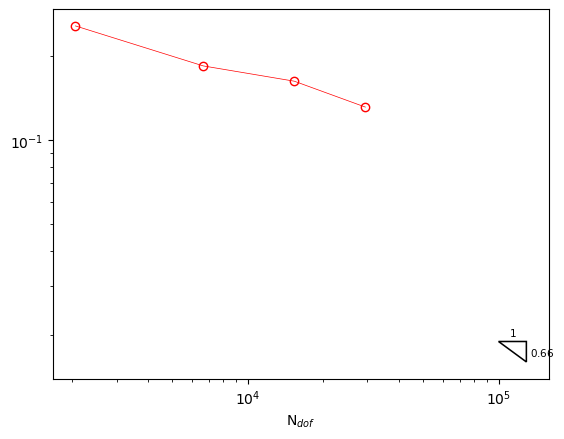

In [103]:
deg=2
[numdofs_geo, nnz_geo, nnzQ_geo , Aherr_geo, Eh_geo, time_mesh_geo, time_solve_geo]=np.loadtxt('Ip'+str(deg)+'n'+str(deg+1)+'geo3D.txt').T

fig, ax = plt.subplots()
# plt.loglog(numdofs[:-1], Aherr[:-1], 'o-',color='black',linewidth=0.5, markerfacecolor='none')
plt.loglog(numdofs_geo[:-1], Aherr_geo[:-1], 'o-',color='red',linewidth=0.5, markerfacecolor='none')

draw_loglog_slope(fig,ax,(1e5,1.9*1e-2),0.5,0.66,inverted=False, color='black', polygon_kwargs=None, label=True, labelcolor=None, label_kwargs=None, zorder=None)

#plt.legend(['uniformly refined mesh','a posteriori mesh','a priori mesh'],loc='lower left',prop={'size': 12})
plt.xlabel("N$_{dof}$")

plt.show()

In [53]:
Aherr_geo

array([25.66359, 18.45354, 16.26594, 13.13878,  0.     ])

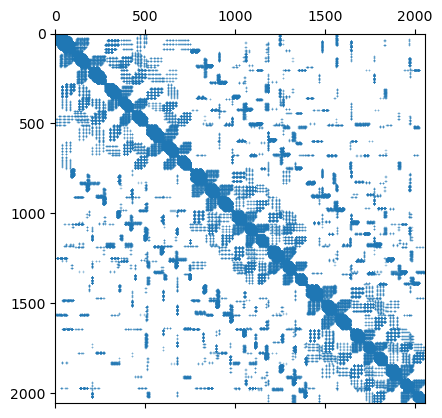

In [29]:
spy(Ah,markersize=0.1)

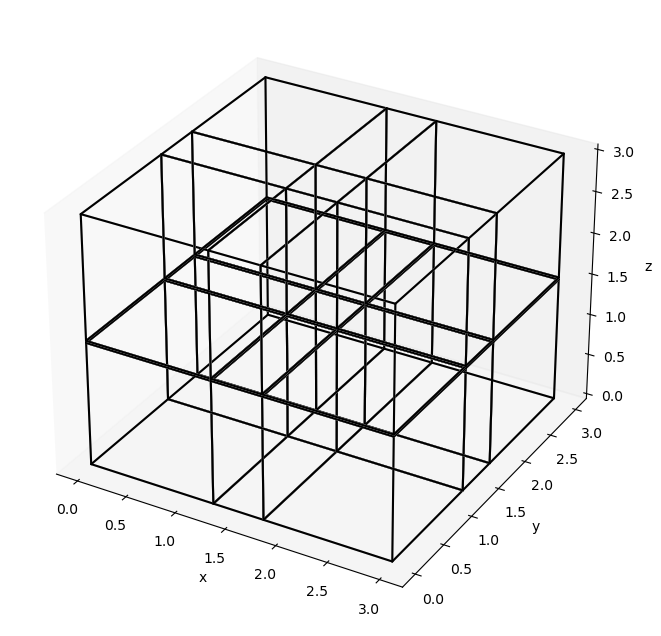

In [9]:
M.draw(knots=1)

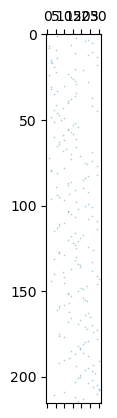

In [17]:
spy(MP.Basis, markersize=0.1)